In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
zip_file = keras.utils.get_file(
    fname = "cora.tgz",
    origin = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract = True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora_extracted/cora")

168052/168052 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [5]:
data_dir = "/root/.keras/datasets/cora_extracted/cora"
print("Files in data_dir:", os.listdir(data_dir))

Files in data_dir: ['README', 'cora.content', 'cora.cites']


In [6]:
citations.sample(frac=1).head()

,target,source
5197,642930,1131184
4611,230879,696343
1918,13205,13208
1903,12638,119761
5191,642894,645870


In [7]:
import os
print(os.path.exists("/root/.keras/datasets/cora_extracted/cora/cora.content"))


True


In [8]:
import os

directory_path = "/root/.keras/datasets/cora_extracted"  # Change to your path
if os.path.exists(directory_path):
    print("Files in directory:", os.listdir(directory_path))
else:
    print("Directory does not exist.")


Files in directory: ['cora']


In [9]:
import os

directory_path = "/root/.keras/datasets/cora_extracted/cora"
if os.path.exists(directory_path):
    print("Files inside 'cora':", os.listdir(directory_path))
else:
    print("The 'cora' folder does not exist.")


Files inside 'cora': ['README', 'cora.content', 'cora.cites']


In [10]:
col_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(os.path.join(data_dir, "cora.content"), sep = "\t", header = None, names = col_names)

papers.shape

(2708, 1435)

In [11]:
papers.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [12]:
papers.subject.value_counts()

,count
subject,
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [13]:
class_val = sorted(papers["subject"].unique())

In [14]:
class_val

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [15]:
class_idx = {name: id for id, name in enumerate(class_val)}
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [16]:
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [17]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])

In [18]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

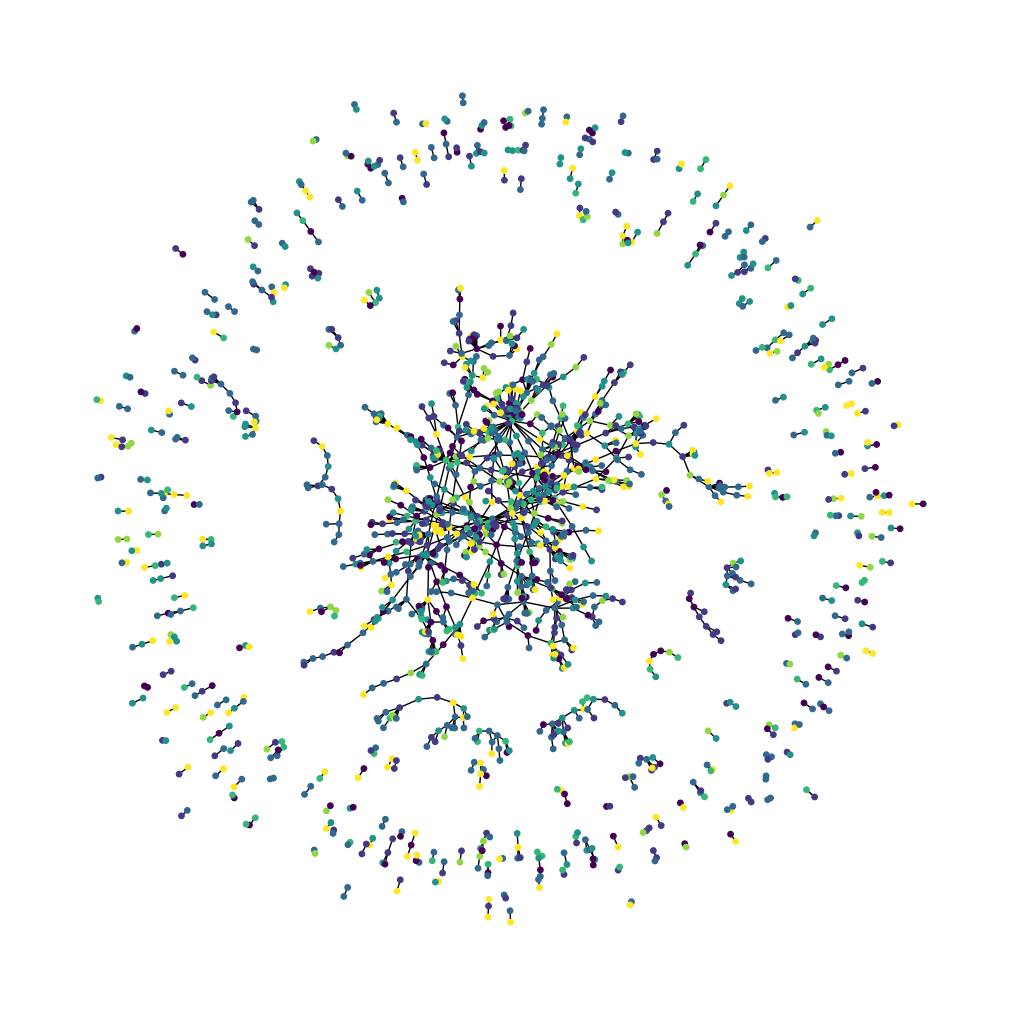

In [19]:
plt.figure(figsize = (10,10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n = 1500))
sub = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size = 15, node_color = sub)

In [20]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
  rand_sel = np.random.rand(len(group_data.index)) <= 0.5
  train_data.append(group_data[rand_sel])
  test_data.append(group_data[~rand_sel])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

train_data.shape
test_data.shape

(1376, 1435)

In [21]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [22]:
def run_experiment(model, x_train, y_train):

  model.compile(
      optimizer = keras.optimizers.Adam(learning_rate),
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
      metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")],
  )

  early_stopping = keras.callbacks.EarlyStopping(
      monitor = "val_acc", patience = 100, restore_best_weights = True
  )

  hist = model.fit(
      x = x_train,
      y = y_train,
      epochs= num_epochs,
      batch_size = batch_size,
      validation_split= 0.15,
      callbacks = [early_stopping]
  )

  return hist

In [23]:
def dis_learn_curve(hist):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,5))

  ax1.plot(hist.history["loss"])
  ax1.plot(hist.history["val_loss"])
  ax1.legend(["train", "test"], loc = "upper right")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")

  ax2.plot(hist.history["acc"])
  ax2.plot(hist.history["val_acc"])
  ax2.legend(["train", "test"], loc="upper right")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  plt.show()

In [24]:
def create_ffn(hidden_units, dropout_rate, name = None):
  fnn_layers = []

  for units in hidden_units:
    fnn_layers.append(layers.BatchNormalization())
    fnn_layers.append(layers.Dropout(dropout_rate))
    fnn_layers.append(layers.Dense(units, activation = tf.nn.gelu))

  return keras.Sequential(fnn_layers, name = name)

In [25]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [26]:
num_features

1433

In [27]:
num_classes

7

In [28]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features            │ (None, 1433)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block1 (Sequential)   │ (None, 32)             │         52,804 │ input_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block2 (Sequential)   │ (None, 32)             │          2,368 │ ffn_block1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection2 (Add)    │ (None, 32)             │              0 │ ffn_block1[0][0],      │
│                           │                        │                │ ffn_block2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block3 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection3 (Add)    │ (None, 32)             │              0 │ skip_connection2[0][0… │
│                           │                        │                │ ffn_block3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block4 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection4 (Add)    │ (None, 32)             │              0 │ skip_connection3[0][0… │
│                           │                        │                │ ffn_block4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block5 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection5 (Add)    │ (None, 32)             │              0 │ skip_connection4[0][0… │
│                           │                        │                │ ffn_block5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logits (Dense)            │ (None, 7)              │            231 │ skip_connection5[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

In [29]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.1797 - loss: 4.1878 - val_acc: 0.1300 - val_loss: 1.9769
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.2113 - loss: 2.5797 - val_acc: 0.1200 - val_loss: 1.9518
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.2521 - loss: 2.3408 - val_acc: 0.2050 - val_loss: 1.9232
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.2603 - loss: 2.1301 - val_acc: 0.3250 - val_loss: 1.8763
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.2676 - loss: 1.9308 - val_acc: 0.2750 - val_loss: 1.8558
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.3055 - loss: 1.9475 - val_acc: 0.3000 - val_loss: 1.8270
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.3333 - loss: 1.7545 - val_acc: 0.4050 - val_loss: 1.7726
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.3839 - loss: 1.6386 - val_acc: 0.4150 - val_loss: 1.7264
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.4111 - loss: 1

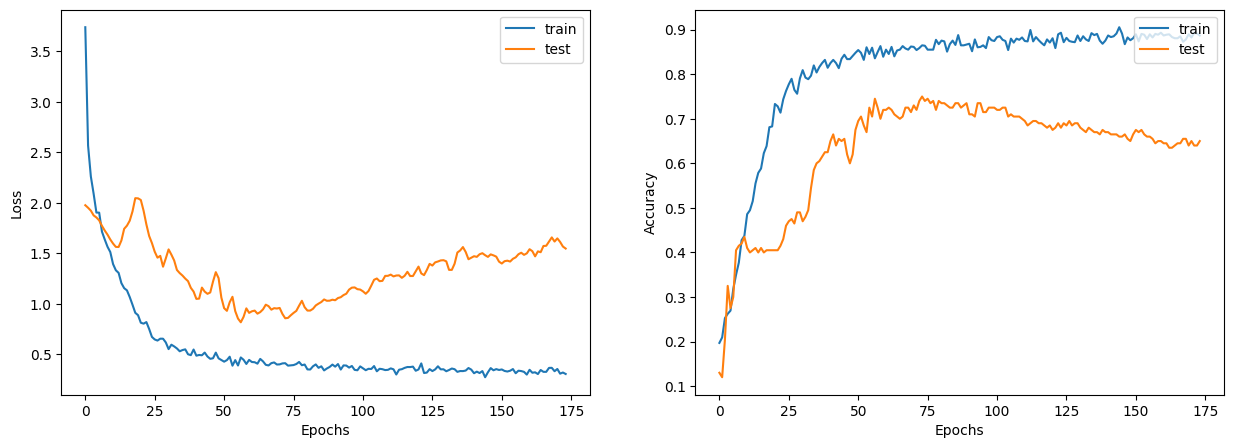

In [30]:
dis_learn_curve(history)

In [31]:
_, test_acc = baseline_model.evaluate(x = x_test, y=y_test, verbose = 0)
print(f"Accuracy: {round(test_acc * 100, 2)}%")

Accuracy: 73.11%


In [32]:
print("Raw test_acc value:", test_acc)

Raw test_acc value: 0.7311046719551086


In [33]:
def gen_rand_prob(num_instances):
  token_prob = x_train.mean(axis = 0)
  instances = []

  for _ in range(num_instances):
    probies = np.random.uniform(size = len(token_prob))
    instance = (probies <= token_prob).astype(int)
    instances.append(instance)

  return np.array(instances)

def dis_class_prob(probies):
  for instance_idx, probs in enumerate(probies):
    print(f"instance {instance_idx + 1}:")
    for class_idx, prob in enumerate(probs):
      print(f"- {class_val[class_idx]}: {round(prob * 100,2)}%")

In [34]:
new_instances = gen_rand_prob(num_classes)
logits = baseline_model.predict(new_instances)
prob = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
dis_class_prob(prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
instance 1:
- Case_Based: 0.01%
- Genetic_Algorithms: 0.5%
- Neural_Networks: 99.4%
- Probabilistic_Methods: 0.02%
- Reinforcement_Learning: 0.01%
- Rule_Learning: 0.02%
- Theory: 0.04%
instance 2:
- Case_Based: 4.58%
- Genetic_Algorithms: 20.29%
- Neural_Networks: 35.15%
- Probabilistic_Methods: 32.17%
- Reinforcement_Learning: 3.29%
- Rule_Learning: 0.72%
- Theory: 3.79%
instance 3:
- Case_Based: 0.27%
- Genetic_Algorithms: 0.26%
- Neural_Networks: 13.04%
- Probabilistic_Methods: 84.7%
- Reinforcement_Learning: 0.28%
- Rule_Learning: 0.38%
- Theory: 1.08%
instance 4:
- Case_Based: 5.58%
- Genetic_Algorithms: 2.14%
- Neural_Networks: 52.06%
- Probabilistic_Methods: 14.84%
- Reinforcement_Learning: 3.37%
- Rule_Learning: 2.64%
- Theory: 19.37%
instance 5:
- Case_Based: 0.41%
- Genetic_Algorithms: 0.72%
- Neural_Networks: 87.95%
- Probabilistic_Methods: 3.38%
- Reinforcement_Learning: 5.41%
- Rule_Learning: 1.88%
- Theory: 0.24%
instance 6:
- Case_

In [65]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [36]:
#Implement a graph convolution layer

In [66]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [67]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [69]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

input_indices = tf.constant([1, 10, 100])
print("GNN output shape:", gnn_model(input_indices))


gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.05067945 -0.03981915  0.0710979   0.13749501  0.02533191 -0.08589764
   0.07342017]
 [-0.14669043  0.04592666  0.1078268  -0.25488344 -0.10349391  0.10766711
  -0.12494587]
 [-0.03860671  0.05021882 -0.06046386 -0.04277406 -0.07130043  0.0592581
  -0.02452406]], shape=(3, 7), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 32)                  │          52,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ (2708, 32)                  │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (3, 7)                      │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,179 (262.42 KB)

 Trainable params: 63,481 (247.97 KB)

 Non-trainable params: 3,698 (14.45 KB)

In [70]:
#Train the GNN model

In [71]:
x_train = train_data.paper_id.to_numpy()
hist = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - acc: 0.2279 - loss: 1.9001 - val_acc: 0.3250 - val_loss: 1.7924
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.3788 - loss: 1.6058 - val_acc: 0.4650 - val_loss: 1.4450
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.6486 - loss: 1.0114 - val_acc: 0.5600 - val_loss: 1.3446
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.7956 - loss: 0.5810 - val_acc: 0.6400 - val_loss: 1.4690
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.9122 - loss: 0.2911 - val_acc: 0.6150 - val_loss: 1.4929
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.9525 - loss: 0.1448 - val_acc: 0.6400 - val_loss: 2.0057
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.9682 - loss: 0.1020 - val_acc: 0.6700 - val_loss: 2.0104
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.9877 - loss: 0.0472 - val_acc: 0.6450 - val_loss: 2.1039
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.9859 - loss: 0

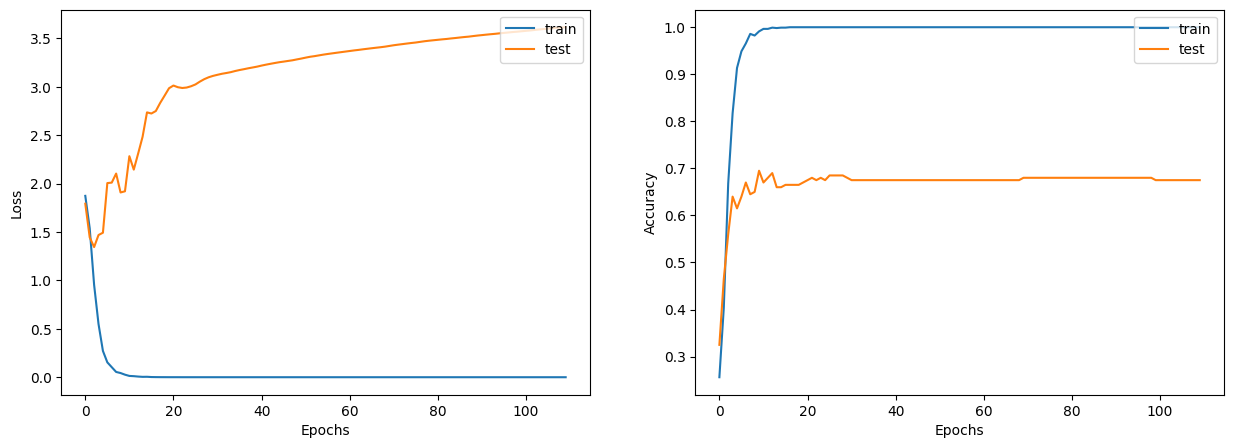

In [72]:
dis_learn_curve(hist)

In [73]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 68.31%


In [74]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [76]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
dis_class_prob(probabilities)

Original node_features shape: (2715, 1433)
Original edges shape: (2, 5478)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
instance 1:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.01%
- Neural_Networks: 99.99%
- Probabilistic_Methods: 0.0%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.0%
instance 2:
- Case_Based: 2.51%
- Genetic_Algorithms: 12.47%
- Neural_Networks: 82.46%
- Probabilistic_Methods: 0.05%
- Reinforcement_Learning: 0.09%
- Rule_Learning: 0.11%
- Theory: 2.3%
instance 3:
- Case_Based: 0.05%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 0.24%
- Probabilistic_Methods: 99.19%
- Reinforcement_Learning: 0.03%
- Rule_Learning: 0.0%
- Theory: 0.49%
instance 4:
- Case_Based: 2.94%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 91.68%
- Probabilistic_Methods: 1.83%
- Reinforcement_Learning: 0.03%
- Rule_Learning: 0.0%
- Theory: 3.51%
instance 5:
- Case_Based: 0.11%
- Genetic_Algorithms: 0.21%
- Neural_Networks: 